In this homework, we'll try to fit different distributions to a single-variable dataset. 

## Getting the data

In [1]:
%%capture
!wget https://raw.githubusercontent.com/avidale/ps4ds2019/master/homework/week3/sample.csv

In [2]:
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline

You can think of the data as long-term return rates of some assets. But, in fact, I just generated them. 

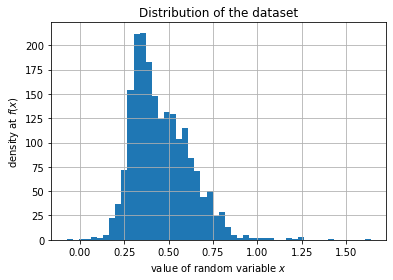

In [3]:
data = pd.read_csv('sample.csv')
x = data['return'].sort_values()
x.hist(bins=50);
plt.xlabel('value of random variable $x$')
plt.ylabel('density at $f(x)$')
plt.title('Distribution of the dataset');

Your goal today will be to find a formula for a distribution that matches our data well. 

## Fitting a normal distribution

Let's start by fitting a normal curve to our data.

In [4]:
mean, sd = x.mean(), x.std()

In [5]:
normal = scipy.stats.norm(mean, sd)

Let's compare normal density with the density of our original data. 

You see that they don't match very well. 

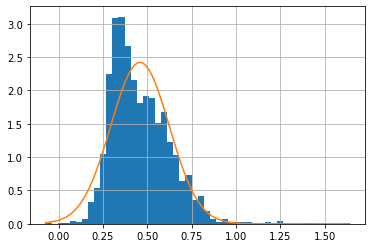

In [6]:
x.hist(bins=50, density=True)
plt.plot(x, normal.pdf(x));

How to evaluate goodness of match numerically? 

One way is to calculate log-likelihood - the sum of logarithms of densities of your model, evaluated at real data points. Or we can divide it by number of samples and report average log-likelihood instead. 

The better the model fits the data, the higher is this mean log-likelihood

In [7]:
mean_log_likelihood = np.log(normal.pdf(x)).mean()
print('ll:', mean_log_likelihood)

ll: 0.38386212580624673


Another way is to calculate CDF of your data and of your model at every point, and report the maximim absolute difference between them. This value is called Kolmogorov-Smirnov (KS) statistic. The smaller it is, the better your model matches the data. 

In [8]:
cdf_of_dataset_at_x = np.linspace(0, 1, num=len(x))
cdf_of_model_at_x = normal.cdf(x)

ks = max(np.abs(cdf_of_dataset_at_x - cdf_of_model_at_x))
print('ks:', ks)

ks: 0.07960519952425787


You see that the maximal error of our CDF is almost 8%. It seems not good, so let's fit a better model. 

But before this, let's do an experiment: deliberately calculate metrics for a bad model and make sure they deteriorate: mean LL decreases, and KS increases.

In [9]:
inappropriate_normal = scipy.stats.norm(0, 1)
print('ll:', np.log(inappropriate_normal.pdf(x)).mean())
print('ks:', max(np.abs(cdf_of_dataset_at_x - inappropriate_normal.cdf(x))))

ll: -1.0375257202721393
ks: 0.563486933260456


## Fitting another distribution

One very obvious problem with fitting normal distribution to our data is that it is symmetric, and the data are not. 

To tackle this problem (and to demonstrate maximum likelihood), let's try to fit the [Gumbel distribution](https://en.wikipedia.org/wiki/Gumbel_distribution) to our data. 

It has two parameters, $\mu$ and $\beta \neq 0 $, which are related to the mode and standart deviation of the distribution, respectively. 

The CDF of Gumbel distribution is given by the formula

$$ F(x) = e^{-e^{-(x-\mu)/\beta}} $$ 

In the next cell, please code a function that takes a number(or vector) $x$ and parameters $\mu$ and $\beta$, and outputs a number (or vector) that corresponds to **density** of Gumbel functions with these parameters at $x$:

In [10]:
def gumbel_cdf(x, mu, beta):
    z = (x - mu) / beta
    return np.exp(-np.exp(-z))

def gumbel_density(x, mu, beta):
    z = (x - mu) / beta
    return np.exp(-1 *(z + np.exp(-1 * z))) / beta


# this is a test that what you coded is really a PDF - at least, for some parameters
bin_size = 0.01
grid = np.arange(-1, 2, step=bin_size)
mu = 0.5
beta = 0.1
grid_density = gumbel_density(grid, mu=mu, beta=beta)
assert all(grid_density >= 0)
assert abs(sum(grid_density * bin_size) - 1) < 0.01  # test that integral of density is 1
assert abs(sum(grid_density * grid * bin_size) - (mu + beta * 0.57721)) < 0.01

Let's plot Gumbel distribution for some (more or less arbitrary) parameters to look at its shape. Well, it's really asymmetric. 

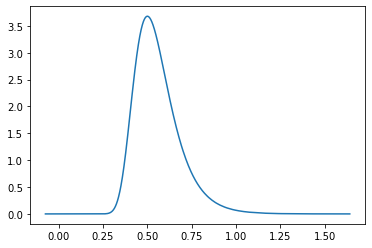

In [11]:
plt.plot(x, gumbel_density(x, mu=0.5, beta=0.1));

In the next cell, you need to write a function that takes a single vector $[\mu, \beta]$ and outputs the negative log-likelihood for our dataset $X$ (the dataset should be taken as a global variable):

$$ NLL(\mu, \beta) = -\sum_{i=1}^n \ln{f(x_i | \mu, \beta)} $$ 

In [12]:
def negative_log_likelihood_gumbel(parameters):
    mu = parameters[0]
    beta = parameters[1]
    # todo: evaluate the likelihood here
    return np.negative(np.sum(np.log(gumbel_density(x, mu , beta))))

print(negative_log_likelihood_gumbel([0, 0.5]))
assert abs(negative_log_likelihood_gumbel([0, 0.5]) - 1286.856) < 0.01

1286.8559872278765


Now let's use `scipy` built-in [optimization engine](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) to find the parameters that maximize the likelihood. 

Under the hood, it uses a second-order optimization algorithm, BFGS, which is something like gradient descent, but takes into account the second derivative as well. 

The result of optimization is an object that, among other things, contains a property `x`: the optimal parameters.  

In [13]:
result = scipy.optimize.minimize(negative_log_likelihood_gumbel, [0, 1])
print(result)

      fun: -884.4074871053813
 hess_inv: array([[8.91867832e-06, 2.14892535e-06],
       [2.14892535e-06, 6.99425466e-06]])
      jac: array([ 0.00000000e+00, -1.52587891e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 48
      nit: 6
     njev: 16
   status: 2
  success: False
        x: array([0.38313534, 0.13615223])


When we plot our fitted Gumbel density against the dataset, it seems to match it better than normal.

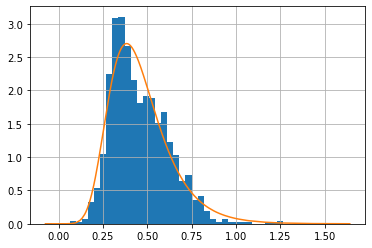

In [14]:
x.hist(density=True, bins=50)
plt.plot(x, gumbel_density(x, *result.x));

We can actually numerically prove it by looking at the metrics. They both improve.

In [15]:
print('ll:', np.log(gumbel_density(x, *result.x)).mean())
print('ks:', max(np.abs(cdf_of_dataset_at_x - gumbel_cdf(x, *result.x))))

ll: 0.44220374355269065
ks: 0.032505744603244624


## Fitting a mixture

Another fruitful idea is to represent an unknown distribution as a mixture (weighted average) of known distributions. 

A popular choice for both univariate and multivariate models is the gaussian mixture model - weighted average of normal distributions. In our case it seems appropriate: the histogram of the dataset looks like a sum of two normal curves with different means and values. 

For our distribution, we'll use a mixed density

$$f(x) = p f_1(x) + (1-p) f_2(x)$$

where $f_1(x)$ and $f_2(x)$ are normal densities with parameters $(\mu_1, \sigma_1^2)$ and $(\mu_2, \sigma_2^2)$ respectively.

In [16]:
def mixture_density(x, p, m1, s1, m2, s2):
    # if parameters are incorrect, return a very small number
    if p <= 0 or p >= 1 or s1 <= 0 or s2 <= 0:
        return x * 0 + 1e-10
    return scipy.stats.norm.pdf(x, m1, s1) * p + scipy.stats.norm.pdf(x, m2, s2) * (1 - p)

def mixture_cdf(x, p, m1, s1, m2, s2):
    # if parameters are incorrect, return a very small number
    if p <= 0 or p >= 1 or s1 <= 0 or s2 <= 0:
        return x * 0 + 1e-10
    return scipy.stats.norm.cdf(x, m1, s1) * p + scipy.stats.norm.cdf(x, m2, s2) * (1 - p)

In the cell below, try to guess values of the parameters that make our mixture model to match the distribution of the dataset well. 

Try to get a KS score below 0.03.

ll: 0.45417772400308865
ks: 0.026291032807483017


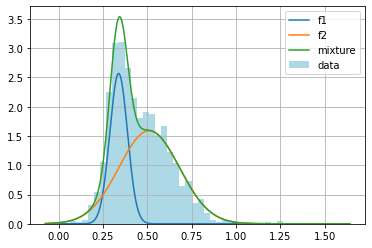

In [17]:
# todo: change these parameters manually to make a good fit
p = 0.322
m1 = 0.338
s1 = 0.05
m2 = 0.51
s2 = 0.17
params = [p, m1, s1, m2, s2]

x.hist(density=True, bins=50, color='lightblue')
plt.plot(x, scipy.stats.norm.pdf(x, m1, s1) * p);
plt.plot(x, scipy.stats.norm.pdf(x, m2, s2) * (1-p));
plt.plot(x, mixture_density(x, *params))
plt.legend(['f1', 'f2', 'mixture', 'data'])

print('ll:', np.log(mixture_density(x, *params)).mean())
print('ks:', max(np.abs(cdf_of_dataset_at_x - mixture_cdf(x, *params))))

Now, instead of maximizing likelihood by guess, let's again use the optimization engine. 

In [18]:
def negative_log_likelihood_mixture(params):
    return -sum(np.log(mixture_density(x, *params)))

In the cell below, save into the `result` variable the result of optimizing 

In [19]:
# todo: save into this variable the result of numerical optimization of the mixture model
result = scipy.optimize.minimize(negative_log_likelihood_mixture, [0.5,0.5,0.5,0.5, 0.5])
print(result)

      fun: -910.0520089339444
 hess_inv: array([[ 1.55500425e-04, -2.46848421e-05,  1.36434944e-06,
         8.43993657e-06, -2.13815623e-06],
       [-2.46848421e-05,  8.15276001e-06,  4.08193302e-08,
        -8.56058440e-06,  3.59758626e-06],
       [ 1.36434944e-06,  4.08193302e-08,  7.90692325e-06,
        -5.33445068e-07,  3.21292004e-07],
       [ 8.43993657e-06, -8.56058440e-06, -5.33445068e-07,
         2.26758516e-05, -2.64368963e-06],
       [-2.13815623e-06,  3.59758626e-06,  3.21292004e-07,
        -2.64368963e-06,  1.13633824e-05]])
      jac: array([ 7.62939453e-05,  1.52587891e-04, -2.74658203e-04,  6.10351562e-05,
       -1.14440918e-04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 612
      nit: 62
     njev: 102
   status: 2
  success: False
        x: array([0.32266765, 0.33878803, 0.05464917, 0.51517575, 0.16927227])


You see that scipy makes a really good job at maximizing log likelihood (KS statistic may, in fact, be slightly worse than the result of manual fitting - because scipy didn't optimize it at all). 


ll: 0.4550260044669724
ks: 0.025600219771254373


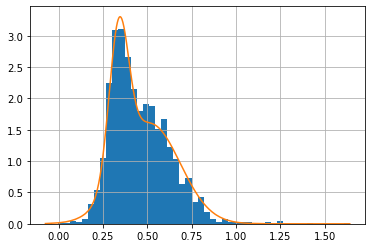

In [20]:
x.hist(density=True, bins=50)
plt.plot(x, mixture_density(x, *result.x));
print('ll:', np.log(mixture_density(x, *result.x)).mean())
print('ks:', max(np.abs(cdf_of_dataset_at_x - mixture_cdf(x, *result.x))))